In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
import matplotlib.ticker as ticker
sns.set()

In [2]:
import sys
sys.path.insert(0, '../')
from model.seq2seq import Seq2Seq, tf
from model.decoding_techniques import BeamSearchDecoder, GreedyDecoder, NucleusDecoder
from utils.processing_utils import *

1 Physical GPUs, 1 Logical GPUs


# Loading data and spliting

In [3]:
data_path = '../processed_data'
mode = 'custom'
all_train = True
if mode=='w2v':
    with open(os.path.join(data_path,'w2v_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_w2v_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='glove':
    with open(os.path.join(data_path,'glove_embeddings_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_cornell.npy'), 'rb') as f:
        missing = np.load(f)
elif mode=='custom':
    with open(os.path.join(data_path,'glove_embeddings_trained_cornell.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove_trained_cornell.npy'), 'rb') as f:
        missing = np.load(f)
        
with open(os.path.join(data_path,'token_mapping_cornell.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data_cornell.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True)  

In [4]:
missing_idx = [token_mapping[i] for i in missing]

In [5]:
len(data)

82957

In [6]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [7]:
pad_token, start_token, end_token,unk_token

('<pad>', '<start>', '<end>', '<unk>')

In [8]:
test = data[2]
[test[i:i+2] for i in range(0,len(test)-1,1)]

[['no no it is my fault we did not have a proper introduction', 'Cameron .'],
 ['Cameron .',
  'the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .'],
 ['the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .',
  'seems like she could get a date easy enough .']]

In [9]:
def slice_data(data):
    X, y = [], []
    for conversation in data:
        pairs = np.array([conversation[i:i+2] for i in range(0,len(conversation)-1,1)])
        X.extend(list(pairs[:,0]))
        y.extend(list(pairs[:,1]))
    return X, y

In [10]:
X, y = slice_data(data)

In [11]:
len(X), len(y)

(221068, 221068)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True)

In [13]:
len(X_train), len(X_test)

(187907, 33161)

In [14]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None, 
              return_len=False):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  length = len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      if return_len:
          return sent_ids,length+1
      else:
          return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  if return_len:
      return sent_ids, max_len
  else:
      return sent_ids


In [15]:
max_len_tokens = 10

In [16]:
if all_train:
    X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X])
    X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y])
    y_train, len_train = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y])
    y_train, len_train = np.array(y_train), np.array(len_train)
else:
    X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_train])
    X_test_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_test])
    X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_train])
    X_test_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_test])
    y_train, len_train = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y_train])
    y_test, len_test = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y_test])
    y_train, len_train, y_test, len_test  = np.array(y_train), np.array(len_train), np.array(y_test), np.array(len_test)


In [17]:
X_train_dec[0], y_train[0], len_train[0]

(array([    1, 29433, 17644, 27689, 29355, 29792, 26519, 29678,     3,
        17689]),
 array([29433, 17644, 27689, 29355, 29792, 26519, 29678,     3, 17689,
            2]),
 10)

In [18]:
len(X_train_dec)

221068

# Building a model 

In [19]:
final_embeddings.shape

(30003, 100)

In [20]:
seq2seq = Seq2Seq(token_mapping, 
         pad_token=token_mapping[pad_token],
         end_token=token_mapping[end_token],
         start_token=token_mapping[start_token],
         max_len=max_len_tokens,
         embeddings=final_embeddings,
         embedding_prefix=mode,
         missing_tokens=np.array(missing_idx).astype(np.int32),
        )

# Training a model

In [21]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train, len_train))
if not all_train:
    val_data = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test, len_test))
else:
    val_data = None

In [22]:
batch_size = 256
num_epochs = 200
epochs_patience = 10

In [23]:
seq2seq.fit(train_data,
            validation_dataset=val_data,
            steps_per_epoch=X_train_enc.shape[0]//batch_size,
            batch_size=batch_size,
            num_epochs=num_epochs,
            epochs_patience=epochs_patience,
            experiment_name='cornell')

  0%|          | 0/200 [00:00<?, ?it/s]

Dir models already exists


  0%|          | 1/200 [02:06<6:59:54, 126.61s/it]



Epoch 0 train loss 6.1157 train perplexity 2231.0615


  1%|          | 2/200 [04:04<6:40:21, 121.32s/it]



Epoch 1 train loss 5.3565 train perplexity 218.4320


  2%|▏         | 3/200 [06:01<6:32:44, 119.61s/it]



Epoch 2 train loss 5.1322 train perplexity 174.1264


  2%|▏         | 4/200 [08:07<6:38:50, 122.09s/it]



Epoch 3 train loss 4.9848 train perplexity 150.1622


  2%|▎         | 5/200 [10:09<6:36:07, 121.88s/it]



Epoch 4 train loss 4.8790 train perplexity 135.0311


  3%|▎         | 6/200 [12:14<6:37:31, 122.94s/it]



Epoch 5 train loss 4.8022 train perplexity 125.0510


  4%|▎         | 7/200 [14:12<6:30:59, 121.55s/it]



Epoch 6 train loss 4.7386 train perplexity 117.4065


  4%|▍         | 8/200 [16:12<6:27:09, 120.99s/it]



Epoch 7 train loss 4.6815 train perplexity 110.8238


  4%|▍         | 9/200 [18:11<6:23:28, 120.46s/it]



Epoch 8 train loss 4.6391 train perplexity 106.0958


  5%|▌         | 10/200 [20:12<6:21:13, 120.39s/it]



Epoch 9 train loss 4.5950 train perplexity 101.4968


  6%|▌         | 11/200 [22:15<6:21:46, 121.20s/it]



Epoch 10 train loss 4.5554 train perplexity 97.5080


  6%|▌         | 12/200 [24:16<6:20:08, 121.32s/it]



Epoch 11 train loss 4.5256 train perplexity 94.5911


  6%|▋         | 13/200 [26:16<6:16:48, 120.90s/it]



Epoch 12 train loss 4.4925 train perplexity 91.4615


  7%|▋         | 14/200 [28:20<6:17:38, 121.82s/it]



Epoch 13 train loss 4.4639 train perplexity 88.8150


  8%|▊         | 15/200 [30:22<6:15:13, 121.69s/it]



Epoch 14 train loss 4.4365 train perplexity 86.4566


  8%|▊         | 16/200 [32:19<6:09:27, 120.48s/it]



Epoch 15 train loss 4.4135 train perplexity 84.3953


  8%|▊         | 17/200 [34:17<6:04:52, 119.63s/it]



Epoch 16 train loss 4.3859 train perplexity 82.0417


  9%|▉         | 18/200 [36:15<6:01:04, 119.03s/it]



Epoch 17 train loss 4.3659 train perplexity 80.5113


 10%|▉         | 19/200 [38:12<5:57:50, 118.62s/it]



Epoch 18 train loss 4.3508 train perplexity 79.1846


 10%|█         | 20/200 [40:10<5:55:00, 118.34s/it]



Epoch 19 train loss 4.3280 train perplexity 77.2826


 10%|█         | 21/200 [42:08<5:52:28, 118.15s/it]



Epoch 20 train loss 4.3028 train perplexity 75.4188


 11%|█         | 22/200 [44:05<5:50:08, 118.03s/it]



Epoch 21 train loss 4.2899 train perplexity 74.5698


 12%|█▏        | 23/200 [46:03<5:47:54, 117.93s/it]



Epoch 22 train loss 4.2757 train perplexity 73.4200


 12%|█▏        | 24/200 [48:01<5:45:41, 117.85s/it]



Epoch 23 train loss 4.2566 train perplexity 71.9549


 12%|█▎        | 25/200 [49:58<5:43:32, 117.78s/it]



Epoch 24 train loss 4.2389 train perplexity 70.7034


 13%|█▎        | 26/200 [51:56<5:41:27, 117.74s/it]



Epoch 25 train loss 4.2279 train perplexity 69.7851


 14%|█▎        | 27/200 [53:54<5:39:28, 117.74s/it]



Epoch 26 train loss 4.2124 train perplexity 68.8507


 14%|█▍        | 28/200 [55:52<5:37:32, 117.75s/it]



Epoch 27 train loss 4.1995 train perplexity 67.8986


 14%|█▍        | 29/200 [57:49<5:35:31, 117.73s/it]



Epoch 28 train loss 4.1813 train perplexity 66.6444


 15%|█▌        | 30/200 [59:47<5:33:44, 117.79s/it]



Epoch 29 train loss 4.1723 train perplexity 66.0978


 16%|█▌        | 31/200 [1:01:45<5:31:41, 117.76s/it]



Epoch 30 train loss 4.1596 train perplexity 65.1470


 16%|█▌        | 32/200 [1:03:42<5:29:33, 117.70s/it]



Epoch 31 train loss 4.1450 train perplexity 64.2245


 16%|█▋        | 33/200 [1:05:40<5:27:34, 117.69s/it]



Epoch 32 train loss 4.1351 train perplexity 63.6227


 17%|█▋        | 34/200 [1:07:38<5:25:40, 117.71s/it]



Epoch 33 train loss 4.1253 train perplexity 62.9523


 18%|█▊        | 35/200 [1:09:35<5:23:38, 117.69s/it]



Epoch 34 train loss 4.1166 train perplexity 62.4168


 18%|█▊        | 36/200 [1:11:33<5:21:39, 117.68s/it]



Epoch 35 train loss 4.1052 train perplexity 61.6874


 18%|█▊        | 37/200 [1:13:31<5:19:36, 117.65s/it]



Epoch 36 train loss 4.0915 train perplexity 60.8376


 19%|█▉        | 38/200 [1:15:28<5:17:37, 117.64s/it]



Epoch 37 train loss 4.0852 train perplexity 60.4218


 20%|█▉        | 39/200 [1:17:26<5:15:36, 117.62s/it]



Epoch 38 train loss 4.0726 train perplexity 59.6550


 20%|██        | 40/200 [1:19:23<5:13:38, 117.62s/it]



Epoch 39 train loss 4.0631 train perplexity 59.1019


 20%|██        | 41/200 [1:21:21<5:11:39, 117.61s/it]



Epoch 40 train loss 4.0538 train perplexity 58.5281


 21%|██        | 42/200 [1:23:19<5:09:44, 117.62s/it]



Epoch 41 train loss 4.0503 train perplexity 58.3261


 22%|██▏       | 43/200 [1:25:17<5:07:55, 117.68s/it]



Epoch 42 train loss 4.0389 train perplexity 57.6314


 22%|██▏       | 44/200 [1:27:14<5:05:55, 117.66s/it]



Epoch 43 train loss 4.0319 train perplexity 57.1946


 22%|██▎       | 45/200 [1:29:12<5:03:59, 117.67s/it]



Epoch 44 train loss 4.0204 train perplexity 56.6088


 23%|██▎       | 46/200 [1:31:09<5:01:57, 117.65s/it]



Epoch 45 train loss 4.0155 train perplexity 56.3095


 24%|██▎       | 47/200 [1:33:07<4:59:57, 117.63s/it]



Epoch 46 train loss 4.0061 train perplexity 55.7768


 24%|██▍       | 48/200 [1:35:05<4:58:00, 117.64s/it]



Epoch 47 train loss 3.9980 train perplexity 55.3214


 24%|██▍       | 49/200 [1:37:03<4:56:12, 117.70s/it]



Epoch 48 train loss 3.9909 train perplexity 54.9094


 25%|██▌       | 50/200 [1:39:00<4:54:13, 117.69s/it]



Epoch 49 train loss 3.9835 train perplexity 54.5326


 26%|██▌       | 51/200 [1:40:58<4:52:14, 117.68s/it]



Epoch 50 train loss 3.9777 train perplexity 54.1536


 26%|██▌       | 52/200 [1:42:56<4:50:15, 117.68s/it]



Epoch 51 train loss 3.9691 train perplexity 53.7623


 26%|██▋       | 53/200 [1:44:53<4:48:29, 117.75s/it]



Epoch 52 train loss 3.9617 train perplexity 53.3127


 27%|██▋       | 54/200 [1:46:51<4:46:26, 117.71s/it]



Epoch 53 train loss 3.9570 train perplexity 53.0210


 28%|██▊       | 55/200 [1:48:53<4:47:28, 118.96s/it]



Epoch 54 train loss 3.9472 train perplexity 52.5306


 28%|██▊       | 56/200 [1:50:54<4:46:39, 119.44s/it]



Epoch 55 train loss 3.9418 train perplexity 52.2200


 28%|██▊       | 57/200 [1:52:55<4:46:16, 120.12s/it]



Epoch 56 train loss 3.9362 train perplexity 51.9499


 29%|██▉       | 58/200 [1:54:54<4:43:34, 119.82s/it]



Epoch 57 train loss 3.9316 train perplexity 51.6738


 30%|██▉       | 59/200 [1:56:54<4:41:33, 119.81s/it]



Epoch 58 train loss 3.9260 train perplexity 51.4067


 30%|███       | 60/200 [1:58:52<4:38:27, 119.34s/it]



Epoch 59 train loss 3.9154 train perplexity 50.8617


 30%|███       | 61/200 [2:00:52<4:36:33, 119.37s/it]



Epoch 60 train loss 3.9118 train perplexity 50.6731


 31%|███       | 62/200 [2:02:53<4:35:43, 119.88s/it]



Epoch 61 train loss 3.9044 train perplexity 50.3211


 32%|███▏      | 63/200 [2:04:54<4:34:14, 120.10s/it]



Epoch 62 train loss 3.9010 train perplexity 50.1256


 32%|███▏      | 64/200 [2:06:56<4:33:33, 120.68s/it]



Epoch 63 train loss 3.8973 train perplexity 49.9485


 32%|███▎      | 65/200 [2:08:58<4:32:35, 121.15s/it]



Epoch 64 train loss 3.8906 train perplexity 49.6040


 33%|███▎      | 66/200 [2:10:58<4:30:04, 120.93s/it]



Epoch 65 train loss 3.8858 train perplexity 49.4003


 34%|███▎      | 67/200 [2:13:01<4:29:11, 121.44s/it]



Epoch 66 train loss 3.8731 train perplexity 48.7666


 34%|███▍      | 68/200 [2:15:05<4:29:00, 122.27s/it]



Epoch 67 train loss 3.8785 train perplexity 48.9840


 34%|███▍      | 69/200 [2:17:08<4:27:34, 122.56s/it]



Epoch 68 train loss 3.8736 train perplexity 48.7712


 35%|███▌      | 70/200 [2:19:12<4:26:11, 122.86s/it]



Epoch 69 train loss 3.8673 train perplexity 48.4325


 36%|███▌      | 71/200 [2:21:11<4:22:04, 121.90s/it]



Epoch 70 train loss 3.8635 train perplexity 48.2916


 36%|███▌      | 72/200 [2:23:11<4:18:22, 121.11s/it]



Epoch 71 train loss 3.8559 train perplexity 47.9311


 36%|███▋      | 73/200 [2:25:12<4:16:10, 121.03s/it]



Epoch 72 train loss 3.8516 train perplexity 47.6959


 37%|███▋      | 74/200 [2:27:10<4:12:31, 120.25s/it]



Epoch 73 train loss 3.8472 train perplexity 47.5087


 38%|███▊      | 75/200 [2:29:08<4:09:09, 119.60s/it]



Epoch 74 train loss 3.8430 train perplexity 47.2926


 38%|███▊      | 76/200 [2:31:07<4:06:35, 119.32s/it]



Epoch 75 train loss 3.8375 train perplexity 47.0451


 38%|███▊      | 77/200 [2:33:05<4:03:50, 118.94s/it]



Epoch 76 train loss 3.8326 train perplexity 46.7822


 39%|███▉      | 78/200 [2:35:02<4:01:03, 118.55s/it]



Epoch 77 train loss 3.8320 train perplexity 46.8048


 40%|███▉      | 79/200 [2:37:00<3:58:29, 118.26s/it]



Epoch 78 train loss 3.8255 train perplexity 46.4297


 40%|████      | 80/200 [2:38:58<3:56:09, 118.08s/it]



Epoch 79 train loss 3.8248 train perplexity 46.4000


 40%|████      | 81/200 [2:40:56<3:54:07, 118.05s/it]



Epoch 80 train loss 3.8207 train perplexity 46.2311


 41%|████      | 82/200 [2:42:54<3:52:11, 118.06s/it]



Epoch 81 train loss 3.8151 train perplexity 45.9567


 42%|████▏     | 83/200 [2:44:52<3:50:13, 118.06s/it]



Epoch 82 train loss 3.8137 train perplexity 45.9033


 42%|████▏     | 84/200 [2:46:50<3:48:18, 118.09s/it]



Epoch 83 train loss 3.8051 train perplexity 45.5210


 42%|████▎     | 85/200 [2:48:49<3:46:39, 118.25s/it]



Epoch 84 train loss 3.8008 train perplexity 45.3191


 43%|████▎     | 86/200 [2:50:46<3:44:25, 118.12s/it]



Epoch 85 train loss 3.7990 train perplexity 45.2422


 44%|████▎     | 87/200 [2:52:44<3:42:18, 118.04s/it]



Epoch 86 train loss 3.7955 train perplexity 45.0678


 44%|████▍     | 88/200 [2:54:42<3:40:10, 117.95s/it]



Epoch 87 train loss 3.7969 train perplexity 45.1155


 44%|████▍     | 89/200 [2:56:40<3:38:08, 117.91s/it]



Epoch 88 train loss 3.7927 train perplexity 44.9184


 45%|████▌     | 90/200 [2:58:38<3:36:05, 117.87s/it]



Epoch 89 train loss 3.7887 train perplexity 44.7664


 46%|████▌     | 91/200 [3:00:35<3:34:04, 117.84s/it]



Epoch 90 train loss 3.7837 train perplexity 44.5286


 46%|████▌     | 92/200 [3:02:33<3:32:06, 117.84s/it]



Epoch 91 train loss 3.7862 train perplexity 44.6319


 46%|████▋     | 93/200 [3:04:31<3:30:07, 117.83s/it]



Epoch 92 train loss 3.7807 train perplexity 44.3945


 47%|████▋     | 94/200 [3:06:29<3:28:09, 117.83s/it]



Epoch 93 train loss 3.7788 train perplexity 44.2977


 48%|████▊     | 95/200 [3:08:27<3:26:12, 117.83s/it]



Epoch 94 train loss 3.7737 train perplexity 44.0699


 48%|████▊     | 96/200 [3:10:25<3:24:13, 117.82s/it]



Epoch 95 train loss 3.7707 train perplexity 43.9251


 48%|████▊     | 97/200 [3:12:22<3:22:14, 117.82s/it]



Epoch 96 train loss 3.7677 train perplexity 43.7967


 49%|████▉     | 98/200 [3:14:20<3:20:16, 117.81s/it]



Epoch 97 train loss 3.7693 train perplexity 43.8799


 50%|████▉     | 99/200 [3:16:19<3:19:01, 118.23s/it]



Epoch 98 train loss 3.7638 train perplexity 43.6433


 50%|█████     | 100/200 [3:18:18<3:17:11, 118.32s/it]



Epoch 99 train loss 3.7602 train perplexity 43.5010


 50%|█████     | 101/200 [3:20:16<3:15:05, 118.23s/it]



Epoch 100 train loss 3.7584 train perplexity 43.4274


 51%|█████     | 102/200 [3:22:14<3:12:54, 118.10s/it]



Epoch 101 train loss 3.7526 train perplexity 43.1531


 52%|█████▏    | 103/200 [3:24:11<3:10:46, 118.01s/it]



Epoch 102 train loss 3.7570 train perplexity 43.3379


 52%|█████▏    | 104/200 [3:26:09<3:08:42, 117.94s/it]



Epoch 103 train loss 3.7541 train perplexity 43.1972


 52%|█████▎    | 105/200 [3:28:07<3:06:40, 117.90s/it]



Epoch 104 train loss 3.7501 train perplexity 43.0387


 53%|█████▎    | 106/200 [3:30:05<3:04:39, 117.86s/it]



Epoch 105 train loss 3.7480 train perplexity 42.9309


 54%|█████▎    | 107/200 [3:32:03<3:02:39, 117.84s/it]



Epoch 106 train loss 3.7497 train perplexity 43.0420


 54%|█████▍    | 108/200 [3:34:00<3:00:40, 117.83s/it]



Epoch 107 train loss 3.7441 train perplexity 42.7864


 55%|█████▍    | 109/200 [3:35:58<2:58:40, 117.81s/it]



Epoch 108 train loss 3.7454 train perplexity 42.8255


 55%|█████▌    | 110/200 [3:37:56<2:56:42, 117.80s/it]



Epoch 109 train loss 3.7417 train perplexity 42.6592


 56%|█████▌    | 111/200 [3:39:54<2:54:43, 117.79s/it]



Epoch 110 train loss 3.7376 train perplexity 42.4848


 56%|█████▌    | 112/200 [3:41:52<2:52:47, 117.82s/it]



Epoch 111 train loss 3.7363 train perplexity 42.4437


 56%|█████▋    | 113/200 [3:43:49<2:50:48, 117.80s/it]



Epoch 112 train loss 3.7357 train perplexity 42.4211


 57%|█████▋    | 114/200 [3:45:47<2:48:40, 117.68s/it]



Epoch 113 train loss 3.7344 train perplexity 42.3750


 57%|█████▊    | 115/200 [3:47:44<2:46:35, 117.60s/it]



Epoch 114 train loss 3.7311 train perplexity 42.2317


 58%|█████▊    | 116/200 [3:49:42<2:44:33, 117.54s/it]



Epoch 115 train loss 3.7298 train perplexity 42.1448


 58%|█████▊    | 117/200 [3:51:39<2:42:31, 117.49s/it]



Epoch 116 train loss 3.7280 train perplexity 42.1036


 59%|█████▉    | 118/200 [3:53:36<2:40:31, 117.46s/it]



Epoch 117 train loss 3.7286 train perplexity 42.1064


 60%|█████▉    | 119/200 [3:55:34<2:38:33, 117.45s/it]



Epoch 118 train loss 3.7237 train perplexity 41.9210


 60%|██████    | 120/200 [3:57:31<2:36:35, 117.44s/it]



Epoch 119 train loss 3.7207 train perplexity 41.7883


 60%|██████    | 121/200 [3:59:29<2:34:38, 117.45s/it]



Epoch 120 train loss 3.7235 train perplexity 41.8838


 61%|██████    | 122/200 [4:01:26<2:32:40, 117.44s/it]



Epoch 121 train loss 3.7206 train perplexity 41.7600


 62%|██████▏   | 123/200 [4:03:24<2:30:44, 117.46s/it]



Epoch 122 train loss 3.7215 train perplexity 41.8080


 62%|██████▏   | 124/200 [4:05:21<2:28:46, 117.45s/it]



Epoch 123 train loss 3.7188 train perplexity 41.7005


 62%|██████▎   | 125/200 [4:07:18<2:26:48, 117.45s/it]



Epoch 124 train loss 3.7158 train perplexity 41.5763


 63%|██████▎   | 126/200 [4:09:16<2:24:51, 117.45s/it]



Epoch 125 train loss 3.7156 train perplexity 41.5762


 64%|██████▎   | 127/200 [4:11:13<2:22:53, 117.44s/it]



Epoch 126 train loss 3.7164 train perplexity 41.6124


 64%|██████▍   | 128/200 [4:13:11<2:20:56, 117.45s/it]



Epoch 127 train loss 3.7092 train perplexity 41.3083


 64%|██████▍   | 129/200 [4:15:08<2:18:58, 117.44s/it]



Epoch 128 train loss 3.7059 train perplexity 41.1579


 65%|██████▌   | 130/200 [4:17:06<2:17:01, 117.45s/it]



Epoch 129 train loss 3.7052 train perplexity 41.1210


 66%|██████▌   | 131/200 [4:19:03<2:15:08, 117.51s/it]



Epoch 130 train loss 3.7056 train perplexity 41.1483


 66%|██████▌   | 132/200 [4:21:01<2:13:09, 117.49s/it]



Epoch 131 train loss 3.7043 train perplexity 41.1157


 66%|██████▋   | 133/200 [4:22:59<2:11:27, 117.73s/it]



Epoch 132 train loss 3.7043 train perplexity 41.0940


 67%|██████▋   | 134/200 [4:24:58<2:09:47, 117.99s/it]



Epoch 133 train loss 3.7022 train perplexity 41.0145


 68%|██████▊   | 135/200 [4:26:56<2:07:47, 117.97s/it]



Epoch 134 train loss 3.7029 train perplexity 41.0585


 68%|██████▊   | 136/200 [4:28:55<2:06:13, 118.34s/it]



Epoch 135 train loss 3.6970 train perplexity 40.7889


 68%|██████▊   | 137/200 [4:30:53<2:04:06, 118.20s/it]



Epoch 136 train loss 3.6957 train perplexity 40.7392


 69%|██████▉   | 138/200 [4:32:51<2:02:03, 118.12s/it]



Epoch 137 train loss 3.6956 train perplexity 40.7345


 70%|██████▉   | 139/200 [4:34:49<2:00:14, 118.28s/it]



Epoch 138 train loss 3.6947 train perplexity 40.7070


 70%|███████   | 140/200 [4:36:47<1:58:09, 118.16s/it]



Epoch 139 train loss 3.6915 train perplexity 40.5804


 70%|███████   | 141/200 [4:38:45<1:56:06, 118.08s/it]



Epoch 140 train loss 3.6954 train perplexity 40.7351


 71%|███████   | 142/200 [4:40:43<1:54:05, 118.03s/it]



Epoch 141 train loss 3.6894 train perplexity 40.4871


 72%|███████▏  | 143/200 [4:42:41<1:52:05, 117.98s/it]



Epoch 142 train loss 3.6890 train perplexity 40.4576


 72%|███████▏  | 144/200 [4:44:39<1:50:07, 117.98s/it]



Epoch 143 train loss 3.6870 train perplexity 40.3933


 72%|███████▎  | 145/200 [4:46:37<1:48:08, 117.97s/it]



Epoch 144 train loss 3.6888 train perplexity 40.4557


 73%|███████▎  | 146/200 [4:48:35<1:46:08, 117.94s/it]



Epoch 145 train loss 3.6861 train perplexity 40.3446


 74%|███████▎  | 147/200 [4:50:33<1:44:15, 118.03s/it]



Epoch 146 train loss 3.6876 train perplexity 40.4383


 74%|███████▍  | 148/200 [4:52:31<1:42:15, 118.00s/it]



Epoch 147 train loss 3.6827 train perplexity 40.1848


 74%|███████▍  | 149/200 [4:54:29<1:40:17, 117.99s/it]



Epoch 148 train loss 3.6817 train perplexity 40.1464


 75%|███████▌  | 150/200 [4:56:27<1:38:19, 117.98s/it]



Epoch 149 train loss 3.6855 train perplexity 40.3481


 76%|███████▌  | 151/200 [4:58:26<1:36:34, 118.25s/it]



Epoch 150 train loss 3.6818 train perplexity 40.1792


 76%|███████▌  | 152/200 [5:00:23<1:34:31, 118.16s/it]



Epoch 151 train loss 3.6825 train perplexity 40.1915


 76%|███████▋  | 153/200 [5:02:21<1:32:30, 118.09s/it]



Epoch 152 train loss 3.6838 train perplexity 40.2625


 77%|███████▋  | 154/200 [5:04:19<1:30:30, 118.04s/it]



Epoch 153 train loss 3.6768 train perplexity 39.9677


 78%|███████▊  | 155/200 [5:06:18<1:28:44, 118.31s/it]



Epoch 154 train loss 3.6799 train perplexity 40.0990


 78%|███████▊  | 156/200 [5:08:16<1:26:40, 118.19s/it]



Epoch 155 train loss 3.6767 train perplexity 39.9829


 78%|███████▊  | 157/200 [5:10:16<1:25:03, 118.68s/it]



Epoch 156 train loss 3.6776 train perplexity 39.9877


 79%|███████▉  | 158/200 [5:12:14<1:22:59, 118.55s/it]



Epoch 157 train loss 3.6744 train perplexity 39.8904


 80%|███████▉  | 159/200 [5:14:12<1:20:52, 118.36s/it]



Epoch 158 train loss 3.6722 train perplexity 39.7893


 80%|████████  | 160/200 [5:16:10<1:18:50, 118.25s/it]



Epoch 159 train loss 3.6722 train perplexity 39.7728


 80%|████████  | 161/200 [5:18:08<1:16:51, 118.23s/it]



Epoch 160 train loss 3.6716 train perplexity 39.7645


 81%|████████  | 162/200 [5:20:07<1:14:56, 118.32s/it]



Epoch 161 train loss 3.6746 train perplexity 39.8646


 82%|████████▏ | 163/200 [5:22:05<1:12:58, 118.35s/it]



Epoch 162 train loss 3.6685 train perplexity 39.6024


 82%|████████▏ | 164/200 [5:24:04<1:10:59, 118.31s/it]



Epoch 163 train loss 3.6647 train perplexity 39.5034


 82%|████████▎ | 165/200 [5:26:02<1:09:00, 118.29s/it]



Epoch 164 train loss 3.6637 train perplexity 39.4571


 83%|████████▎ | 166/200 [5:28:00<1:06:59, 118.22s/it]



Epoch 165 train loss 3.6665 train perplexity 39.5574


 84%|████████▎ | 167/200 [5:29:58<1:04:58, 118.15s/it]



Epoch 166 train loss 3.6621 train perplexity 39.4134


 84%|████████▍ | 168/200 [5:31:56<1:03:00, 118.15s/it]



Epoch 167 train loss 3.6649 train perplexity 39.5077


 84%|████████▍ | 169/200 [5:33:54<1:01:01, 118.11s/it]



Epoch 168 train loss 3.6621 train perplexity 39.3838


 85%|████████▌ | 170/200 [5:35:52<59:02, 118.09s/it]  



Epoch 169 train loss 3.6651 train perplexity 39.5184


 86%|████████▌ | 171/200 [5:37:50<57:04, 118.08s/it]



Epoch 170 train loss 3.6622 train perplexity 39.3773


 86%|████████▌ | 172/200 [5:39:48<55:06, 118.10s/it]



Epoch 171 train loss 3.6564 train perplexity 39.1633


 86%|████████▋ | 173/200 [5:41:46<53:07, 118.07s/it]



Epoch 172 train loss 3.6561 train perplexity 39.1368


 87%|████████▋ | 174/200 [5:43:44<51:09, 118.05s/it]



Epoch 173 train loss 3.6557 train perplexity 39.1097


 88%|████████▊ | 175/200 [5:45:42<49:10, 118.02s/it]



Epoch 174 train loss 3.6513 train perplexity 38.9444


 88%|████████▊ | 176/200 [5:47:42<47:22, 118.45s/it]



Epoch 175 train loss 3.6585 train perplexity 39.2257


 88%|████████▊ | 177/200 [5:49:40<45:21, 118.31s/it]



Epoch 176 train loss 3.6540 train perplexity 39.0753


 89%|████████▉ | 178/200 [5:51:39<43:28, 118.57s/it]



Epoch 177 train loss 3.6529 train perplexity 39.0311


 90%|████████▉ | 179/200 [5:53:38<41:36, 118.86s/it]



Epoch 178 train loss 3.6537 train perplexity 39.0533


 90%|█████████ | 180/200 [5:55:37<39:33, 118.68s/it]



Epoch 179 train loss 3.6520 train perplexity 38.9811


 90%|█████████ | 181/200 [5:57:35<37:32, 118.56s/it]



Epoch 180 train loss 3.6526 train perplexity 39.0237


 91%|█████████ | 182/200 [5:59:33<35:31, 118.41s/it]



Epoch 181 train loss 3.6497 train perplexity 38.8874


 92%|█████████▏| 183/200 [6:01:31<33:31, 118.30s/it]



Epoch 182 train loss 3.6484 train perplexity 38.8745


 92%|█████████▏| 184/200 [6:03:30<31:33, 118.36s/it]



Epoch 183 train loss 3.6514 train perplexity 38.9521


 92%|█████████▎| 185/200 [6:05:28<29:34, 118.28s/it]



Epoch 184 train loss 3.6488 train perplexity 38.8705


 93%|█████████▎| 186/200 [6:07:26<27:34, 118.21s/it]



Epoch 185 train loss 3.6481 train perplexity 38.8306


 94%|█████████▎| 187/200 [6:09:24<25:36, 118.17s/it]



Epoch 186 train loss 3.6484 train perplexity 38.8421


 94%|█████████▍| 188/200 [6:11:22<23:37, 118.15s/it]



Epoch 187 train loss 3.6483 train perplexity 38.8505


 94%|█████████▍| 189/200 [6:13:20<21:39, 118.14s/it]



Epoch 188 train loss 3.6443 train perplexity 38.7005


 95%|█████████▌| 190/200 [6:15:18<19:41, 118.12s/it]



Epoch 189 train loss 3.6428 train perplexity 38.6358


 96%|█████████▌| 191/200 [6:17:16<17:42, 118.09s/it]



Epoch 190 train loss 3.6405 train perplexity 38.5269


 96%|█████████▌| 192/200 [6:19:14<15:44, 118.08s/it]



Epoch 191 train loss 3.6470 train perplexity 38.7790


 96%|█████████▋| 193/200 [6:21:12<13:46, 118.07s/it]



Epoch 192 train loss 3.6464 train perplexity 38.7572


 97%|█████████▋| 194/200 [6:23:10<11:48, 118.07s/it]



Epoch 193 train loss 3.6448 train perplexity 38.6934


 98%|█████████▊| 195/200 [6:25:08<09:50, 118.08s/it]



Epoch 194 train loss 3.6382 train perplexity 38.4498


 98%|█████████▊| 196/200 [6:27:07<07:52, 118.15s/it]



Epoch 195 train loss 3.6416 train perplexity 38.5711


 98%|█████████▊| 197/200 [6:29:05<05:54, 118.16s/it]



Epoch 196 train loss 3.6352 train perplexity 38.3427


 99%|█████████▉| 198/200 [6:31:03<03:56, 118.14s/it]



Epoch 197 train loss 3.6355 train perplexity 38.3399


100%|█████████▉| 199/200 [6:33:02<01:58, 118.34s/it]



Epoch 198 train loss 3.6382 train perplexity 38.4387


100%|██████████| 200/200 [6:35:00<00:00, 118.50s/it]



Epoch 199 train loss 3.6368 train perplexity 38.3864
Finished training


In [24]:
seq2seq.save_models(decoder_path='decoder_all_data_cornell.h5',
                   encoder_path='encoder_all_data_cornell.h5')

# Testing predictions and other helpful stuff

In [25]:
from utils.model_utils import plot_attention

In [26]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [27]:
def give_answer(decoder, sentence, inverse_token_mapping, pad_unk=True, process_sentence=True, len_output=50,
               beam_size=3,
              top_p=0.95,
               beam_search=False,
               nucleus_sampling = False,
               show_attention=False):
      if process_sentence:
        cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
        unk_token = pad_token if pad_unk else "<unk>"
        processed_sentence = process(cleaned_sentence, unk_token)
        mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
      else:
        mapped_sentence = sentence
      if beam_search:
        prediction = decoder.decode(mapped_sentence, beam_size)
      elif nucleus_sampling:
        prediction = decoder.decode(mapped_sentence, len_output, top_p)
      else:
          prediction = decoder.decode(mapped_sentence, len_output, show_attention)
      if show_attention and not beam_search:
        prediction, attention = prediction
      answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
      if show_attention and not beam_search:
            plot_attention(attention,sentence.split(' '), answer.split(' '))
      return answer

In [28]:
greedy_decoder = GreedyDecoder(decoder=seq2seq.decoder,
             encoder=seq2seq.encoder,
             max_len=max_len_tokens,
             start_token=token_mapping[start_token],
             end_token=token_mapping[end_token])

../utils/model_utils.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
../utils/model_utils.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


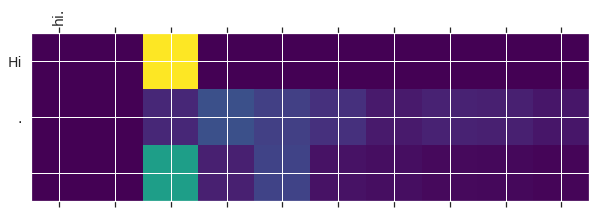

'Hi .'

In [29]:
give_answer(greedy_decoder, 'hi. ', inverse_token_mapping, show_attention=True)

In [30]:
beam_search_decoder = BeamSearchDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [31]:
give_answer(beam_search_decoder, 'hi ', inverse_token_mapping, show_attention=False,
           beam_search=True)

'Hi hon .'

In [32]:
nucleus_decoder = NucleusDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [33]:
give_answer(nucleus_decoder, 'hi', inverse_token_mapping, nucleus_sampling=True, top_p=0.75)

'Okay samuel'

# Dialogue generation and question answering

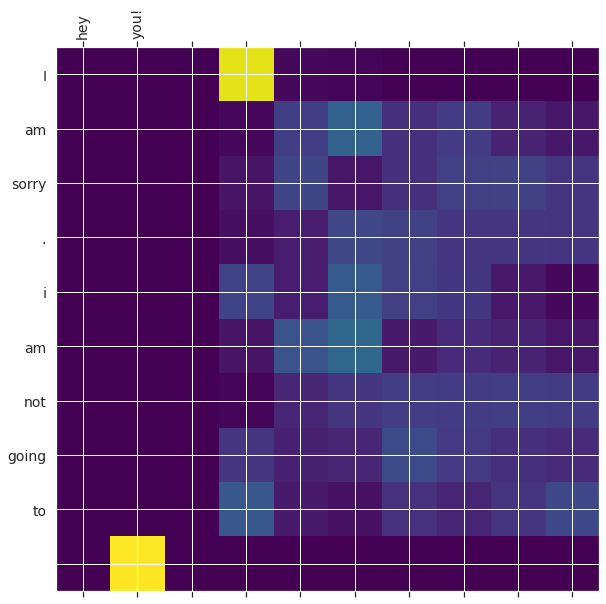

------------------------------
Test replica : hey you!
Bot greedy answer : I am sorry . i am not going to
Bot beam search answer : Do not worry about it .
Bot nucleus answr : Dorothy asked the television is what i need the
------------------------------


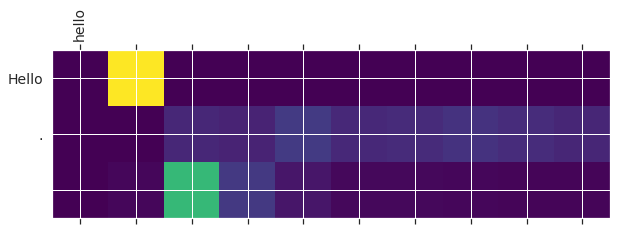

------------------------------
Test replica : hello
Bot greedy answer : Hello .
Bot beam search answer : Hello .
Bot nucleus answr : Where ?
------------------------------


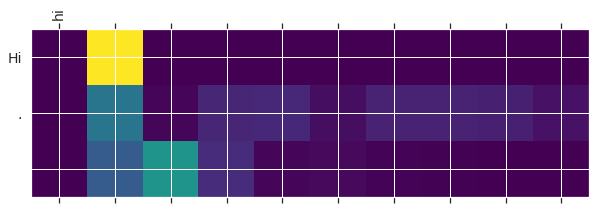

------------------------------
Test replica : hi
Bot greedy answer : Hi .
Bot beam search answer : Hi hon .
Bot nucleus answr : You know where to ya meet a dollar bucks
------------------------------


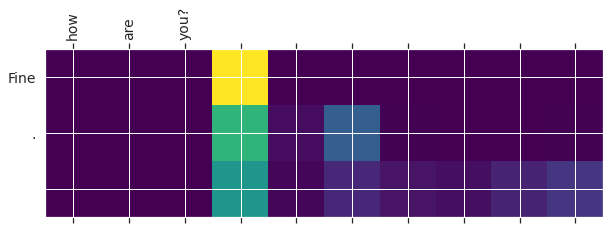

------------------------------
Test replica : how are you?
Bot greedy answer : Fine .
Bot beam search answer : Fine fine . i am fine .
Bot nucleus answr : Oh right now do not i put you any
------------------------------


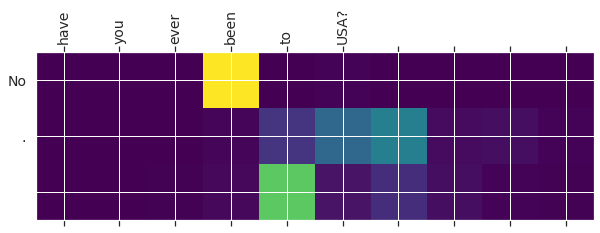

------------------------------
Test replica : have you ever been to USA?
Bot greedy answer : No .
Bot beam search answer : No .
Bot nucleus answr : Nothing ! and you do
------------------------------


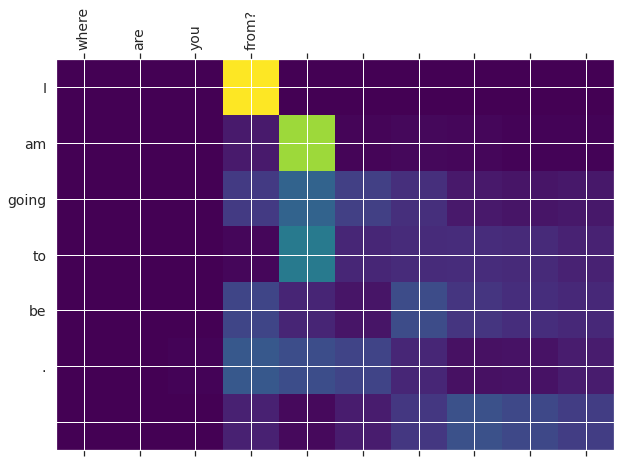

------------------------------
Test replica : where are you from?
Bot greedy answer : I am going to be .
Bot beam search answer : In europe europe .
Bot nucleus answr : Down on .
------------------------------


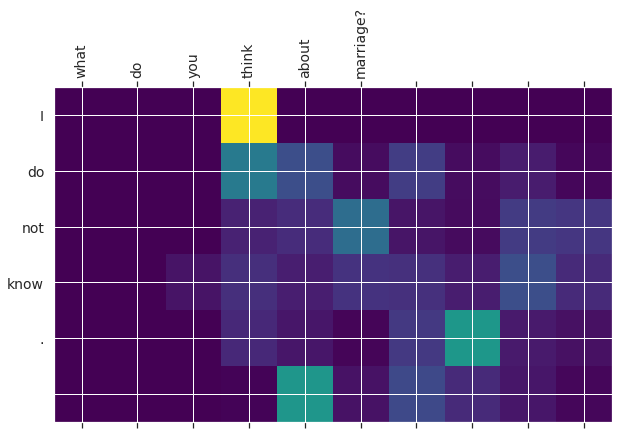

------------------------------
Test replica : what do you think about marriage?
Bot greedy answer : I do not know .
Bot beam search answer : I do not know . it is just a
Bot nucleus answr : Have i point with you do
------------------------------


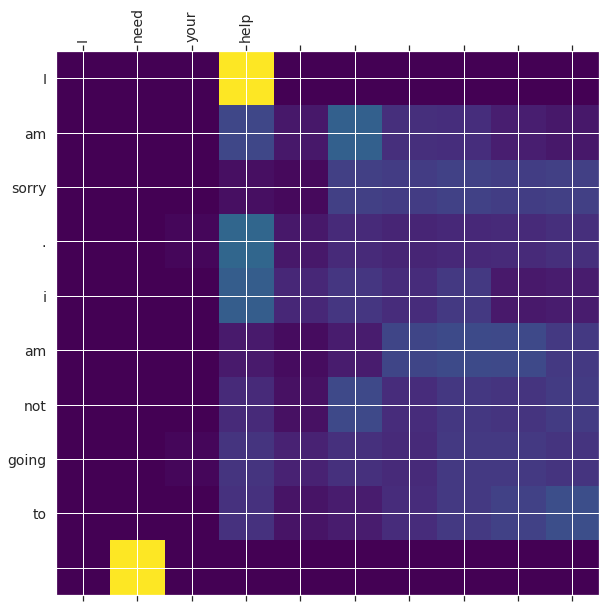

------------------------------
Test replica : I need your help
Bot greedy answer : I am sorry . i am not going to
Bot beam search answer : I do not know what you are talking about
Bot nucleus answr : Go away the little back you know something leia
------------------------------


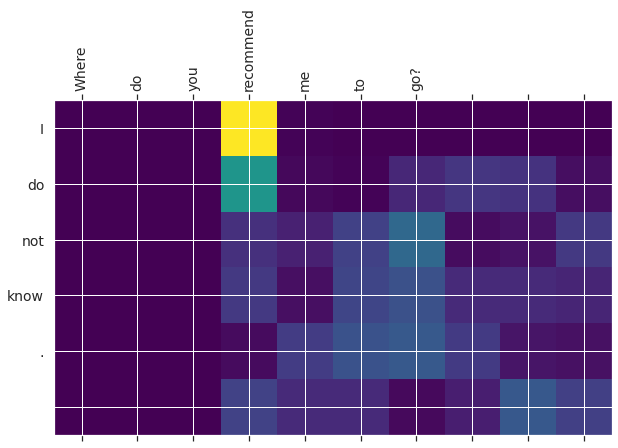

------------------------------
Test replica : Where do you recommend me to go?
Bot greedy answer : I do not know .
Bot beam search answer : I do not want to talk to you .
Bot nucleus answr : No i think not it so long a beer
------------------------------


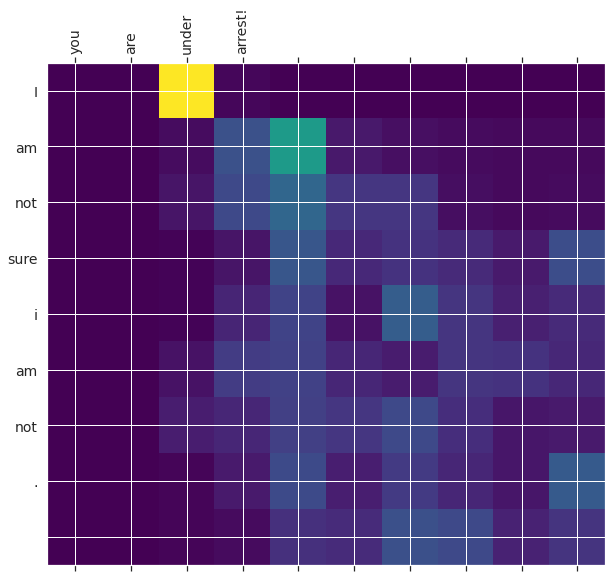

------------------------------
Test replica : you are under arrest!
Bot greedy answer : I am not sure i am not .
Bot beam search answer : No .
Bot nucleus answr : How long have i been acting with him
------------------------------


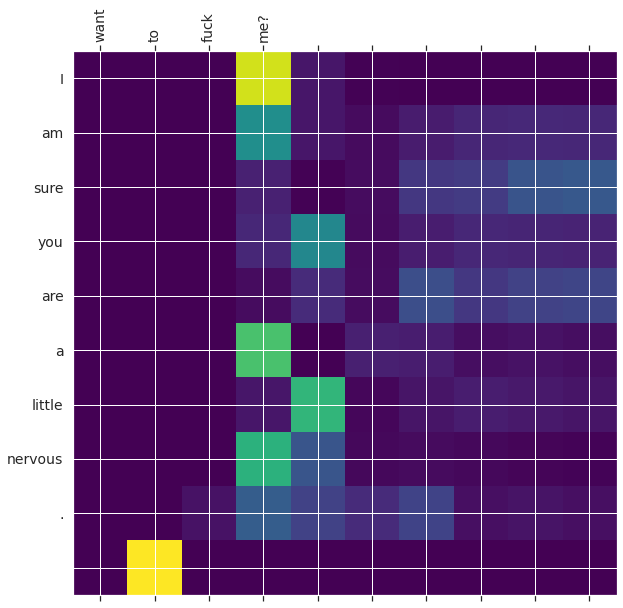

------------------------------
Test replica : want to fuck me?
Bot greedy answer : I am sure you are a little nervous .
Bot beam search answer : Sure .
Bot nucleus answr : We got some numbers . and we cannot a
------------------------------


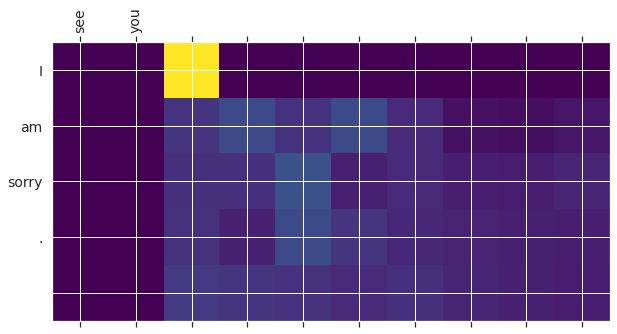

------------------------------
Test replica : see you
Bot greedy answer : I am sorry .
Bot beam search answer : No .
Bot nucleus answr : Alice it is late you know that group a
------------------------------


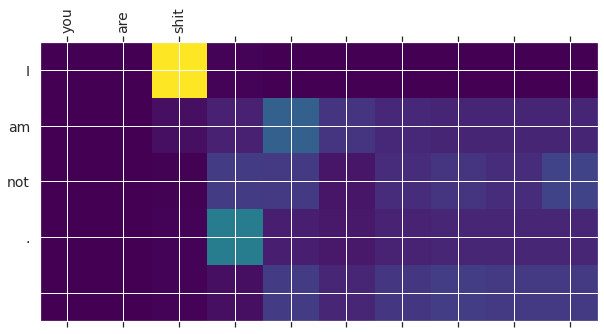

------------------------------
Test replica : you are shit
Bot greedy answer : I am not .
Bot beam search answer : No i am not .
Bot nucleus answr : Go up
------------------------------


In [34]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?',
           'see you',
           'you are shit']
for i in replicas:
    greedy_answer = give_answer(greedy_decoder, i, inverse_token_mapping, show_attention=True)
    beam_search_answer = give_answer(beam_search_decoder, i, inverse_token_mapping,
           beam_search=True,
           beam_size=3)
    nucleus_answer = give_answer(nucleus_decoder, i, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.75)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print('Bot nucleus answr : {}'.format(nucleus_answer))
    print(30*'-')


# Gabberish dialogue

In [35]:
n_replicas = 100
count = 0
replica = str(input()).strip()
while count<n_replicas:
    replica = give_answer(nucleus_decoder, replica, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.95)
    print('\n--- {}'.format(replica))
    count+=1

рш

--- Dr harry when yesterday everything <unk> paradise at itself

--- Believe yourself wild tricked do the game try after

--- George me is tomorrow gus can you just rest

--- Ready pard can you ask to bust little k

--- Make us pulse drive our will order me to

--- But sir right so daddys asleep fully her son

--- Counts my future does ! quick go meet him

--- Bob ben give it alright straight or soap

--- Jesus it could seem seem fishy time just fun

--- Has italian thing just somehow in general county voyage

--- As to lydia in and so if she are

--- Heres little after behind you the information this her

--- Must hit t stones i heres huh and u

--- Sometimes adam just went wrong for lunch dinner over

--- Goodbye vig at keeping too <unk> roy ever begun

--- Sorry ! take him waiting last way something who

--- Am sorry

--- Like every me u but u my treat file

--- Everybodys orders away well doc everythings that okay the

--- Heres deal ms that when ask he already supposed

--- Ja

# Interactive usage

In [36]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    greedy_answer = give_answer(greedy_decoder, inp, inverse_token_mapping, show_attention=False)
    beam_search_answer = give_answer(beam_search_decoder, inp, inverse_token_mapping,
           beam_search=True,
           beam_size=7)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Beam answer : {}'.format(beam_search_answer))
    print('Greedy answer : {}'.format(greedy_answer))
    print(30*'-')

hello
------------------------------
Replica : hello
Beam answer : Hello .
Greedy answer : Hello .
------------------------------
where are you from bro?
------------------------------
Replica : where are you from bro?
Beam answer : That is up .
Greedy answer : I am going to be .
------------------------------
where are you from?
------------------------------
Replica : where are you from?
Beam answer : In europe europe .
Greedy answer : I am going to be .
------------------------------
hey
------------------------------
Replica : hey
Beam answer : Where is the trunk ?
Greedy answer : What ?
------------------------------
hey ?
------------------------------
Replica : hey ?
Beam answer : What are you doing here ?
Greedy answer : Yes .
------------------------------
what is your name?
------------------------------
Replica : what is your name?
Beam answer : Berger norwegian .
Greedy answer : Berger norwegian .
------------------------------
fuck you
------------------------------
Replic

KeyboardInterrupt: Interrupted by user